In [85]:
import math
import scipy
import random
import gym
import numpy as np
from control import *
import matplotlib.pyplot as plt
import tensorflow as tensor
import keras.backend as K
from collections import deque
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda, concatenate
from keras.optimizers import Adam
from keras import regularizers
from  control.matlab import *

from ReplayBuffer import ReplayBuffer
from DDPG_Actor_Network import ActorNetwork
from DDPG_Critic_Network import CriticNetwork

import timeit


# OU = OU()


# class DDPG(St, St_next):
#     def __init__(self):
#         self.sess = K.get_session()
#         # update rate for target model
#         self.TAU = 0.01
#         # experience replay 
#         self.memory_buffer = deque(maxlen=50000)
#         # discount rate for q value
#         self.gamma = 0.95
#         # epislon of action selection
#         self.epsilon = 1.0
#         # discount rate for epislon
#         self.epsilon_decay = 0.995
#         # min epislon of e-greedy
#         self.epsilon_min = 0.01
#         # actor learning rate
#         self.actor_lr = 0.0001
#         # critic learning rate
#         self.critic_lr = 0.0001
        
#         # DDPG model
#         self.actor = self._build_actor()
#         self.critic = self._build_critic()

#         # DDPG target model
#         self.target_actor = self._build_actor()
#         self.target_actor.set_weights(self.actor.get_weights())
#         self.target_critic = self._build_critic()
#         self.target_critic.set_weights(self.critic.get_weights())

#         # Gradient function
#         self.get_critic_grad = self.critic_gradient()
#         self.actor_optimizer()

#         def _build_actor(self):
#             inputs = Input(shape=(6,), name='state_input')
#             x = Dense(200, activation='relu6', kernel_regularizers=regularizers.l2(0.01))(inputs)
#             x = Dense(200, activation='relu6', kernel_regularizers=regularizers.l2(0.01))(x)
#             output = Dense(10, activation='relu', kernel_regularizers=regularizers.l2(0.01))(x)

#             model = Model(inputs=inputs, outputs=output)
#             model.compile(loss='mse', optimizer=Adam(lr=self.actor_lr))
#             return model
        
#         def _build_critic(self):
#             inputs = Input(shape=(6,), name='state_input')
#             x = Dense(200, activation='relu6', kernel_regularizers=regularizers.l2(0.01))(inputs)
#             x = Dense(200, activation='relu6', kernel_regularizers=regularizers.l2(0.01))(x)
#             output = Dense(10, activation='relu', kernel_regularizers=regularizers.l2(0.01))(x)

#             model = Model(inputs=inputs, outputs=output)
#             model.compile(loss='mse', optimizer=Adam(lr=self.critic_lr))
#             return model

Tracking_array = []

class environment():
    def reset(self):
        self.kp = 29
        self.ki = 1
        self.kd = 0.001
        self.curIter = 0
        reset_state = [0,0, 0,0,0,0]
#         reset_error = random.uniform(2,10)
        self.error = []
    
        return reset_state


    def env(self, action,curIter):
        self.kp = action[0]
        self.ki = action[1]
        self.kd = action[2]
        # current iteration: 0~100(default setting by scipy.signal.step())
        self.curIter = curIter
        # variable: Jl & Kt 
        # it varies according to different systems (1~3)
        if curIter in range(1000):
            sys_sel = 1
        elif curIter in range(2000,4000):
            sys_sel = 2
        elif curIter in range(4000,6000):
            sys_sel = 1
        elif curIter in range(6000,8000):
            sys_sel = 3
        elif curIter in range(8000,10000):
            sys_sel = 1
        elif curIter in range(10000, 12000):
            sys_sel = 2
        elif curIter in range(12000, 14000):
            sys_sel = 3
        elif curIter in range(14000, 16000):
            sys_sel = 1
        elif curIter in range(16000, 18000):
            sys_sel = 2
        elif curIter in range(18000, 20000):
            sys_sel  = 3
            
        if sys_sel == 1:
            Jl = 2.5*1e-3
            Kt = 1
        elif sys_sel == 2:
            Jl = 6.3*1e-3
            Kt = 1
        elif sys_sel == 3:
            Jl = 2.5*1e-3
            Kt = 3
        # constant
        Jm = 6.329*1e-4
        Tsigma = 1.1*1e-5
        Tsigman = 1.25*1e-4
        B = 3.0*1e-4
        Ksf = (60*1)/(2500*5*1e-3)
        amplitude = 2000
        # sample period: 100us
        T_period = []
        T_ini = 0
        for _ in range(100):
            T_period.append(T_ini)
            T_ini += 500000*1e-6
            
        '''
        speed loop
        Yspeed(s)/W(s) = B1*kd*s^2 + B1*kp*s + B1*ki / A1*s^3 + (B1*kd+A2)*s^2 + (A3+B1*kp)*s + B1*ki
        '''
        A1 = (Jm + Jl) * Tsigman
        A2 = B * Tsigman + (Jm + Jl)
        A3 = B
        B1 = Kt * Ksf
        # speed loop feedback lti system 
        speed_fb_lti = scipy.signal.lti([B1*self.kd, B1*self.kp, B1*self.ki], [A1, A2+B1*self.kd, A3+B1*self.kp, B1*self.ki])
        # Angular velocity: Xt
#         t1, Xt = scipy.signal.step(speed_fb_lti, T=T_period)
        # Amplitute: 2000
#         Xt = amplitude * Xt
        '''
        step response
        Y(s)/e(t) = 1
        '''
#         feedback_sys = tf([B1*self.kd, B1*self.kp, B1*self.ki], [A1, A2+B1*self.kd, A3+B1*self.kp, B1*self.ki])
            
#         Xt, t = step(feedback_sys)
        ## optimal values
        kp_optimal = 8.27e-5 
        ki_optimal = 1.5936e-5 
        kd_optimal  = .00000001
        
        speed_fb_lti_optimal = scipy.signal.lti([B1*kd_optimal, B1*kp_optimal, B1*ki_optimal], [A1, A2+B1*kd_optimal, A3+B1*kp_optimal, B1*ki_optimal])
            
        t1, optimal = scipy.signal.step(speed_fb_lti, T=T_period)

        ##########################
        t1_list = []
        t2_list = []
        t3_list = []
        for t1 in range(20):
            t1_list.append(t1*0.05)
        for _ in range(20, 80):
            t2_list.append(1)
        for t3 in range(80, 100):
            t3_list.append(5-t3*0.05)
        system = scipy.signal.lti(1, 1)
        t11, Xt1, _ = scipy.signal.lti.output(system, t1_list, T=T_period[0:20])
        t12, Xt2, _ = scipy.signal.lti.output(system, t2_list, T=T_period[20:80])
        t13, Xt3, _ = scipy.signal.lti.output(system, t3_list, T=T_period[80:100])
        # The signal of tracking
        t2 = np.append(np.append(t11, t12), t13)
        Ht = np.append(np.append(Xt1, Xt2), Xt3)
        # Trapezoidal response
        t1, Xt, _ = scipy.signal.lti.output(speed_fb_lti, Ht, T=t2)
#         plt.plot(t1,Xt)
#         plt.show()

        
        # step response feedback lti system
#         step_fb_lti = scipy.signal.lti(1, 1)
#         Input signal: Ht
#         t2, Ht = scipy.signal.step(step_fb_lti, T=T_period)
#         Amplitute: 2000
#         1000 iterations
        
        
        
        
        # Tracking error of the output angle of the servo system
        Et = optimal - Xt
        # current time spot of iteration
        max_len = len(Xt)
#         max_len = 100000
        # Integral of absolute error: IAE
        # iae = 0
        # if self.curIter == 0:
        #     iae = 0
        # else:
        #     iae = abs(absolute_Et[self.curIter] - absolute_Et[self.curIter - 1]) * 1
        if self.curIter == 0:
            Xt_last = Xt[0]
            Et_last = Et[0]
            Xt_cur = Xt[self.curIter]
            Et_cur = Et[self.curIter]
            Xt_next = Xt[self.curIter + 1]
            Ht_next = optimal[self.curIter + 1]
            Et_next = Et[self.curIter + 1]
            Ht_a2t = optimal[self.curIter + 2]
            Ht_a3t = optimal[self.curIter + 3]
        elif self.curIter > max_len - 4:
            Xt_last = Xt[self.curIter - 1]
            Et_last = Et[self.curIter - 1]
            Xt_cur = Xt[self.curIter]
            Et_cur = Et[self.curIter]
            Xt_next = Xt[max_len - 1]
            Ht_next = optimal[max_len -1]
            Et_next = Et[max_len -1]
            Ht_a2t = optimal[max_len -1]
            Ht_a3t = optimal[max_len -1]
        else:
            Xt_last = Xt[self.curIter - 1]
            Et_last = Et[self.curIter - 1]
            Xt_cur = Xt[self.curIter]
            Et_cur = Et[self.curIter]
            Xt_next = Xt[self.curIter + 1]
            Ht_next = optimal[self.curIter + 1]
            Et_next = Et[self.curIter + 1]
            Ht_a2t = optimal[self.curIter + 2]
            Ht_a3t = optimal[self.curIter + 3]
        St = [Xt_last, Et_last, Xt_cur, Et_cur, Ht_next, Ht_a2t]
        St_next = [Xt_cur, Et_cur, Xt_next, Et_next, Ht_a2t, Ht_a3t]
        Tracking_array.append(Xt_cur)

        absolute_It = 0

#         reward  = math.exp(pow(((0.9 *(Et_cur) / amplitude + 0.1 * abs(absolute_It) / amplitude)), 2)/ (-2) * pow(10, 2))
        reward  = 1/(abs(math.exp(abs(Et_cur))))
        done  = False
        return St_next,reward,done

#         plt.plot(t1, Xt)
        # plt.xlabel('Time(s)')
        # plt.ylabel('Angular velocity')
        # plt.savefig('Angular velocity.jpg')
        # plt.show()
        # plt.plot(t2, Ht)
        # plt.xlabel('Time(s)')
        # plt.ylabel('Tracking signal')
        # plt.savefig('Tracking signal.jpg')
#         plt.show()
#         return Xt
        # return St, S(t+1), reward, t1: for plot usage
        
 























PID = environment()

def play():
    
    BUFFER_SIZE = 100000
    BATCH_SIZE = 125
    GAMMA = 0.90
    TAU = 0.001     #Target Network HyperParameters
    LRA = 0.0001    #Learning rate for Actor
    LRC = 0.001 
    action_size = 3
    action_dim = 3
    state_dim  = 6
    np.random.seed(1337)
    
    vision = False
    EXPLORE = 100000.
    episode_count = 10000
    max_steps = 100
    reward = 0
    done = False
    step = 0
    epsilon = 1
    indicator = 0
    train_indicator = 1
    
    config = tensor.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tensor.Session(config=config)
    from keras import backend as K
    K.set_session(sess)
    
    actor = ActorNetwork(sess, state_dim, action_dim, BATCH_SIZE, TAU, LRA)
    critic = CriticNetwork(sess, state_dim, action_dim, BATCH_SIZE, TAU, LRC)
    buff = ReplayBuffer(BUFFER_SIZE)    #Create replay buffer
    
    for i in range(episode_count):
        print("Episode : " + str(i) + " Replay Buffer " + str(buff.count())) 
#         total_reward = 0.
#         Xt_last = 1444
#         Et_last = 22
#         Xt_cur = 344
#         Et_cur = 534
#         Ht_next = 2000
#         Ht_a2t = 2000
        state = PID.reset()
        print("reset_error", state)

        
        for j in range(max_steps):
            
            loss = 0
            epsilon  -= 1.0/ EXPLORE
            a_t = np.zeros([1, action_size])
            noise_t = np.zeros([1, action_size])
            
            a_t_original = actor.model.predict(np.array([state]))
#             print("a_t_original: ", a_t_original)
            noise_t[0][0] = train_indicator * max(epsilon, 0) * OU.function(a_t_original[0][0], 2 , 0.01, 0.01)
            noise_t[0][1] = train_indicator * max(epsilon, 0) * OU.function(a_t_original[0][1], 2 , 0.01, 0.01)
            noise_t[0][2] = train_indicator * max(epsilon, 0) * OU.function(a_t_original[0][2], 2 , 0.01, 0.01)
            
            a_t[0][0] = a_t_original[0][0] + noise_t[0][0]
            a_t[0][1] = a_t_original[0][1] + noise_t[0][1]
            a_t[0][2] = a_t_original[0][2] + noise_t[0][2]
            
                    
#             print("a_t", a_t[0])
            next_state, reward,done  = PID.env(a_t[0], j)
            print("current_state", next_state[1])
#             print("next_state",next_state[3])
#             print("reward", reward)
            buff.add(state, a_t[0], reward, next_state, done)   
            batch = buff.getBatch(BATCH_SIZE)
            states = np.asarray([e[0] for e in batch])
            actions = np.asarray([e[1] for e in batch])
            rewards = np.asarray([e[2] for e in batch])
            next_states = np.asarray([e[3] for e in batch])
            dones = np.asarray([e[4] for e in batch])
            y_t = np.asarray([e[1] for e in batch])
            target_q_values = critic.target_model.predict([next_states, actor.target_model.predict(next_states)])
            for k in range(len(batch)):
                if dones[k]:
                    y_t[k] = rewards[k]
                else:
                    y_t[k] = rewards[k] + GAMMA*target_q_values[k]
                    
        
            if (train_indicator):
                loss += critic.model.train_on_batch([(states),actions], y_t) 
#                 print("loss",loss)
                a_for_grad = actor.model.predict(states)
                if buff.count() <= BATCH_SIZE:
                    K= buff.count()
                else:
                    K = BATCH_SIZE
                states = states.reshape(K,6)
                grads = critic.gradients(states, a_for_grad)
                
                actor.train(states, grads)
                actor.target_train()
                critic.target_train()
                
            
            state = next_state
#             total_reward += reward
#             print("total_reward", reward)
            
            
#             if done:
#                 if j == 999:
#                     iterations.append(j)
#                 break 
            
                
if __name__ == "__main__":
    play()
warnings.filterwarnings("ignore")



Episode : 0 Replay Buffer 0
reset_error [0, 0, 0, 0, 0, 0]
current_state 0.0
current_state 0.9443108277816484
current_state 0.896429228935934
current_state 0.8465590769165854
current_state 0.7980076095894877
current_state 0.7497620439119639
current_state 0.6986131727086934
current_state 0.6491574441483132
current_state 0.6003913415467121
current_state 0.5493213661640914
current_state 0.5005851293477768
current_state 0.45019158552959715
current_state 0.4007705281069919
current_state 0.349597945389986
current_state 0.30038049103330244
current_state 0.25040006835100703
current_state 0.20065703571822535
current_state 0.15066247934925125
current_state 0.10069879665094161
current_state 0.050528075854292975
current_state 5.1195039961871025e-05
current_state 0.0005496753929973286
current_state 0.0005603686372694927
current_state 0.0003347070318739931
current_state 0.0003651639645438909
current_state 0.00034671749404580066
current_state 0.0003182815146672846
current_state 0.0002807718051076602


current_state 4.433606037190785e-06
current_state 2.3366481093356484e-06
current_state 5.1383232516633015e-06
current_state 5.617505473676232e-06
current_state 3.4470670385866597e-06
current_state 3.628425901625043e-06
current_state 4.878817518205736e-06
current_state 4.6096515828875084e-06
current_state 3.6886401182378847e-06
current_state 4.42070905393166e-06
current_state 4.232043740781677e-06
current_state 3.342337748790669e-06
current_state 2.972648302734804e-06
current_state 3.5054628291231182e-06
current_state 4.094943351073965e-07
current_state 3.19112894620055e-06
current_state 1.483253869616341e-06
current_state 2.9448774822027346e-06
current_state 3.254805362451485e-06
current_state 3.446655201688742e-06
current_state 2.963498666352926e-06
current_state 3.1660558328372446e-06
current_state 3.1864469962616937e-06
current_state 3.195009468326404e-06
current_state 3.1880879047818667e-06
current_state 2.932838144342753e-06
current_state 3.020697839861697e-06
current_state 2.3009

current_state 6.54910105812867e-07
current_state 7.512980714219353e-07
current_state 1.291738201181225e-06
current_state 1.4006206408012645e-06
current_state 1.2058995524366622e-06
current_state 1.448230550593621e-06
current_state 1.4802776815425744e-06
current_state 1.0478442924455322e-06
current_state 7.607392414898939e-07
current_state 1.185466578457195e-06
current_state 1.2170994281301972e-06
current_state 1.2242893501213103e-06
current_state 1.0313402318828935e-06
current_state 1.202515248044378e-06
current_state 1.350402526245631e-06
current_state 1.282650927691975e-06
current_state 1.1457069115650143e-06
current_state 1.0201248736851909e-06
current_state 1.137574079379533e-06
current_state 0.049989312025193966
current_state 0.09998209347499798
current_state 0.14997675855057224
current_state 0.19997488422480247
current_state 0.24997280138042544
current_state 0.2999726753774197
current_state 0.34997213445948294
current_state 0.3999729257941338
current_state 0.4499729708414175
curr

current_state 0.8499829256898328
current_state 0.8999834335451498
current_state 0.9499833116686659
Episode : 7 Replay Buffer 700
reset_error [0, 0, 0, 0, 0, 0]
current_state 0.0
current_state 0.9499143962387577
current_state 0.8999719597695098
current_state 0.8499885059075223
current_state 0.7999959459767201
current_state 0.7499998188170545
current_state 0.7000019824574535
current_state 0.6500033684813771
current_state 0.6000041256961279
current_state 0.5500052622237825
current_state 0.5000064563957964
current_state 0.45000736617959636
current_state 0.400008475758617
current_state 0.3500106441497879
current_state 0.3000110692679371
current_state 0.25001345097019745
current_state 0.20001594242884324
current_state 0.1500188230090227
current_state 0.10002285739717998
current_state 0.05002788294397231
current_state 3.2529759509736245e-05
current_state 2.197286280802846e-05
current_state 1.1693252331523851e-05
current_state 9.125545798904788e-06
current_state 5.237517047951279e-06
current_s

current_state 4.5399380872446216e-06
current_state 5.396827975623353e-06
current_state 2.5304755408850355e-06
current_state 4.8662446709979434e-06
current_state 4.5222205371509006e-06
current_state 5.193045097495741e-06
current_state 4.580724314418028e-06
current_state 3.877062819235277e-06
current_state 3.2196149590824064e-06
current_state 3.6707899022658808e-06
current_state 3.7345376215913717e-06
current_state 4.532835915060929e-06
current_state 3.5326742213737106e-06
current_state 4.383378235273128e-06
current_state 2.3862243655470294e-06
current_state 4.079318609240268e-06
current_state 4.336637654978048e-06
current_state 4.290767806169882e-06
current_state 4.0127031895043075e-06
current_state 3.99394353522986e-06
current_state 4.023675532760507e-06
current_state 3.753961322128241e-06
current_state 5.561635020301381e-07
current_state 3.919992679790596e-06
current_state 3.5245930556371263e-06
current_state 3.734697518020802e-06
current_state 3.4961485462225994e-06
current_state 3.1

ValueError: cannot convert float NaN to integer

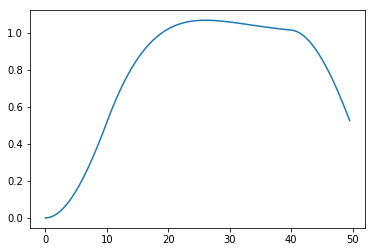

In [49]:
environment = environment()
a = [8.27e-5, 1.5936e-5 ,.00000001]

environment.env(a,1)

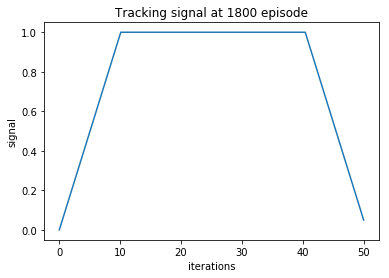

In [84]:
plt.plot(np.linspace(0, 50, num=100),np.absolute(Tracking_array[80000:80100]))
plt.title("Tracking signal at 1800 episode")
plt.xlabel("iterations")
plt.ylabel("signal")
plt.show()

In [81]:
len(Tracking_array)

99646